### Required Imports and Installations

In [1]:
import os
import sqlite3

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

%matplotlib inline

2022-05-10 18:33:51.052822: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-10 18:33:51.052842: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Data Ingestion & Pre-Processing

In [2]:
con1 = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb.sqlite"))
con2 = sqlite3.connect(os.path.join(os.getcwd(), "../Database/results.sqlite"))

In [3]:
stock_approx_df = pd.read_sql_query("SELECT * from stock_data WHERE ticker='TSLA'", con1)

stock_approx_df = stock_approx_df.drop(columns = ['category', 'ticker'])

stock_approx_df["stockDate"] = stock_approx_df["stockDate"].astype("datetime64")
stock_approx_df["open"] = stock_approx_df["open"].astype("float64")
stock_approx_df["close"] = stock_approx_df["close"].astype("float64")

stock_approx_df.rename(columns = {'stockDate': 'date'}, inplace = True)

In [4]:
stock_approx_df

,date,open,close,high,low
0,2020-03-30,102.0520,100.4260,103.3294,98.246
1,2020-03-31,100.2500,104.8000,108.5920,99.400
2,2020-04-01,100.8000,96.3120,102.7910,95.020
3,2020-04-02,96.2060,90.8940,98.8520,89.280
4,2020-04-03,101.9000,96.0020,103.0980,93.678
...,...,...,...,...,...
720,2022-03-20,904.8575,917.2175,934.1000,897.165
721,2022-03-21,914.9800,921.1600,942.8500,907.090
722,2022-03-22,930.0000,993.9800,997.8600,921.750
723,2022-03-23,979.9400,999.1100,1040.7000,976.400


In [5]:
stock_df = pd.read_sql_query("SELECT * from stocks WHERE ticker='TSLA'", con1)

stock_df = stock_df.drop(columns = ['category', 'ticker', 'pre_market', 'afterHours'])

stock_df["stockDate"] = stock_df["stockDate"].astype("datetime64")
stock_df["open"] = stock_df["open"].astype("float64")
stock_df["close"] = stock_df["close"].astype("float64")
stock_df["high"] = stock_df["high"].astype("float64")
stock_df["low"] = stock_df["low"].astype("float64")

stock_df.rename(columns = {'stockDate': 'date'}, inplace = True)

In [6]:
stock_df

,date,open,close,high,low
0,2020-03-30,102.052,100.426,103.3294,98.246
1,2020-03-31,100.250,104.800,108.5920,99.400
2,2020-04-01,100.800,96.312,102.7910,95.020
3,2020-04-02,96.206,90.894,98.8520,89.280
4,2020-04-03,101.900,96.002,103.0980,93.678
...,...,...,...,...,...
497,2022-03-18,874.490,905.390,907.8500,867.390
498,2022-03-21,914.980,921.160,942.8500,907.090
499,2022-03-22,930.000,993.980,997.8600,921.750
500,2022-03-23,979.940,999.110,1040.7000,976.400


In [7]:
tweet_df = pd.read_sql_query("SELECT * from new_scored_tweets WHERE category='EVs'", con2)

tweet_df

,category,date,count,ind_neg,ind_neu,ind_pos,wted_neg,wted_neu,wted_pos,neg_counts,neu_counts,pos_counts
0,EVs,2020-04-07,405,29.760626,42.419716,33.819664,61.686187,105.406782,237.907026,55,92,258
1,EVs,2020-04-08,243,29.776691,47.333942,25.889368,64.262435,109.520843,69.216720,71,121,51
2,EVs,2020-04-09,209,29.311668,44.887577,28.800758,57.566045,100.556852,50.877107,57,118,34
3,EVs,2020-04-10,272,24.159784,47.111198,29.729010,39.036394,120.448533,112.515063,39,84,149
4,EVs,2020-04-11,514,29.267159,42.111918,28.620923,289.783706,153.905570,70.310696,382,68,64
...,...,...,...,...,...,...,...,...,...,...,...,...
718,EVs,2022-03-26,362,24.960136,79.639015,51.400856,49.414182,185.991661,126.594145,40,181,141
719,EVs,2022-03-27,269,21.682240,88.565294,51.752467,28.025453,142.857427,98.117120,26,132,111
720,EVs,2022-03-28,200,13.536305,79.159981,43.303711,16.151524,104.101375,79.747098,12,115,73
721,EVs,2022-03-29,262,26.068008,96.631897,63.300098,34.526736,123.377115,104.096144,33,132,97


In [8]:
tweet_df["date"] = tweet_df["date"].astype("datetime64")

tweet_df["wted_neg"] = tweet_df["wted_neg"].astype("float64")
tweet_df["wted_neu"] = tweet_df["wted_neu"].astype("float64")
tweet_df["wted_pos"] = tweet_df["wted_pos"].astype("float64")

tweet_df["ind_neg"] = tweet_df["ind_neg"].astype("float64")
tweet_df["ind_neu"] = tweet_df["ind_neu"].astype("float64")
tweet_df["ind_pos"] = tweet_df["ind_pos"].astype("float64")

tweet_df["neg_counts"] = tweet_df["neg_counts"].astype("int32")
tweet_df["neu_counts"] = tweet_df["neu_counts"].astype("int32")
tweet_df["pos_counts"] = tweet_df["pos_counts"].astype("int32")

In [9]:
temp_tweet_df = tweet_df.copy(deep=True)

temp_merged_df = pd.merge(stock_approx_df, temp_tweet_df, on=['date'])
temp_merged_df = temp_merged_df.sort_values(by=['date']).reset_index(drop=True)
temp_merged_df = temp_merged_df.drop(columns=['date', 'category'])

scaler = MinMaxScaler()

temp_norm_df = scaler.fit_transform(temp_merged_df)

temp_norm_df = pd.DataFrame(temp_norm_df, columns = [ 'open', 'close', 'high', 'low', \
                                                      'count','ind_neg','ind_neu', 'ind_pos', \
                                                      'wted_neg', 'wted_neu', 'wted_pos', \
                                                      'neg_counts', 'neu_counts', 'pos_counts'])
print(temp_norm_df.head())
print("\nData dimensions:", temp_norm_df.shape)

       open     close      high       low     count   ind_neg   ind_neu  \
0  0.000000  0.000000  0.001377  0.000000  0.081803  0.278674  0.176300   
1  0.001635  0.000605  0.000000  0.000178  0.043167  0.278874  0.211060   
2  0.003037  0.004916  0.003175  0.004461  0.035058  0.273078  0.193756   
3  0.005531  0.011871  0.009961  0.006570  0.050083  0.208868  0.209484   
4  0.006778  0.015348  0.013354  0.007624  0.107799  0.272524  0.174122   

    ind_pos  wted_neg  wted_neu  wted_pos  neg_counts  neu_counts  pos_counts  
0  0.143917  0.012963  0.048889  0.241882    0.012069    0.029245    0.169668  
1  0.100014  0.013676  0.051495  0.058898    0.016010    0.042925    0.026316  
2  0.116132  0.011823  0.045817  0.039005    0.012562    0.041509    0.014543  
3  0.121271  0.006698  0.058417  0.105865    0.008128    0.025472    0.094183  
4  0.115136  0.076056  0.079609  0.060085    0.092611    0.017925    0.035319  

Data dimensions: (717, 14)


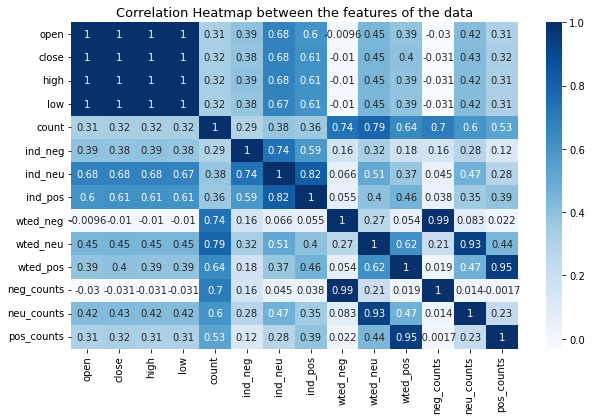

In [10]:
#Correlation analysis between different features - to determine useful features

plt.figure(figsize=(10,6))
sns.heatmap(temp_norm_df.corr(),cmap=plt.cm.Blues,annot=True)
plt.title('Correlation Heatmap between the features of the data', fontsize=13)
plt.show()

<AxesSubplot:>

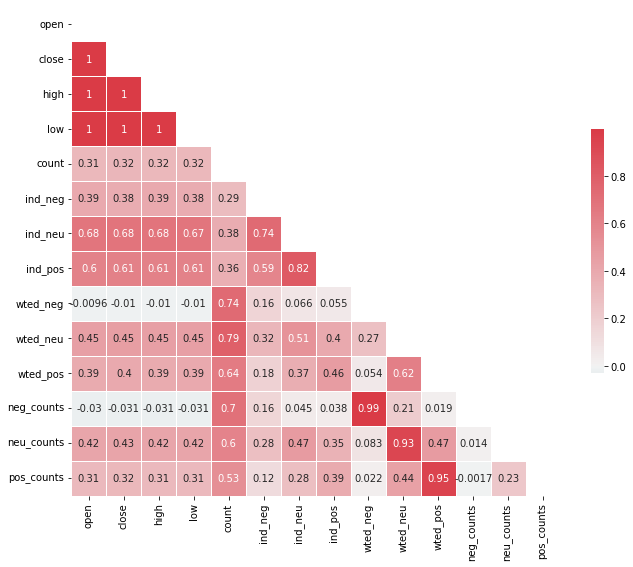

In [11]:
# Compute the correlation matrix
corr = temp_norm_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

From the above correlation heatmap, we can observe that the columns **ind_neg, ind_neu, ind_pos** present the best correlation between Tweet sentiments and stock market data.

In [12]:
#Drop unnecessary columns

tweet_df = tweet_df.drop(columns = ['category', 'count', 'wted_neg', 'wted_neu', 'wted_pos',\
                                    'neg_counts', 'neu_counts', 'pos_counts'])

In [13]:
tweet_df

,date,ind_neg,ind_neu,ind_pos
0,2020-04-07,29.760626,42.419716,33.819664
1,2020-04-08,29.776691,47.333942,25.889368
2,2020-04-09,29.311668,44.887577,28.800758
3,2020-04-10,24.159784,47.111198,29.729010
4,2020-04-11,29.267159,42.111918,28.620923
...,...,...,...,...
718,2022-03-26,24.960136,79.639015,51.400856
719,2022-03-27,21.682240,88.565294,51.752467
720,2022-03-28,13.536305,79.159981,43.303711
721,2022-03-29,26.068008,96.631897,63.300098


In [14]:
#Garbage collection

del temp_tweet_df
del temp_merged_df
del temp_norm_df

In [15]:
merged_df = pd.merge(stock_approx_df, tweet_df, on=['date'])
merged_df = merged_df.sort_values(by=['date']).reset_index(drop=True)
merged_df

,date,open,close,high,low,ind_neg,ind_neu,ind_pos
0,2020-04-07,109.0000,109.0900,113.0000,106.468,29.760626,42.419716,33.819664
1,2020-04-08,110.8400,109.7680,111.4416,106.666,29.776691,47.333942,25.889368
2,2020-04-09,112.4180,114.6000,115.0364,111.422,29.311668,44.887577,28.800758
3,2020-04-10,115.2250,122.3950,122.7182,113.764,24.159784,47.111198,29.729010
4,2020-04-11,116.6285,126.2925,126.5591,114.935,29.267159,42.111918,28.620923
...,...,...,...,...,...,...,...,...
712,2022-03-20,904.8575,917.2175,934.1000,897.165,23.400652,77.231102,43.368240
713,2022-03-21,914.9800,921.1600,942.8500,907.090,29.305679,109.190102,64.504219
714,2022-03-22,930.0000,993.9800,997.8600,921.750,27.974422,112.280266,95.745312
715,2022-03-23,979.9400,999.1100,1040.7000,976.400,35.987617,101.290970,71.721405


In [16]:
df = merged_df.copy(deep = True)

df.describe()

,open,close,high,low,ind_neg,ind_neu,ind_pos
count,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000
mean,633.797699,634.884971,649.765274,618.367076,31.380694,74.093164,55.339251
std,272.886468,273.336322,279.684587,266.557496,12.196334,25.903602,21.766363
min,109.000000,109.090000,111.441600,106.468000,7.401396,17.495420,7.823344
25%,421.390000,420.980000,430.500000,410.580000,22.233269,53.404079,38.339832
50%,671.758000,670.000000,687.240000,657.510000,29.305679,67.530556,51.607182
75%,823.738400,821.530000,848.180000,801.725000,38.347519,95.472717,69.616793
max,1234.410000,1229.910000,1243.490000,1217.000000,87.635785,158.870064,188.457495


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     717 non-null    datetime64[ns]
 1   open     717 non-null    float64       
 2   close    717 non-null    float64       
 3   high     717 non-null    float64       
 4   low      717 non-null    float64       
 5   ind_neg  717 non-null    float64       
 6   ind_neu  717 non-null    float64       
 7   ind_pos  717 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 44.9 KB


In [18]:
#Normalize data

def normalize_data(df):
    scaler = MinMaxScaler()
    
    df['open'] = scaler.fit_transform(df.open.values.reshape(-1, 1))
    df['close'] = scaler.fit_transform(df.close.values.reshape(-1, 1))
    df['high'] = scaler.fit_transform(df.high.values.reshape(-1, 1))
    df['low'] = scaler.fit_transform(df.low.values.reshape(-1, 1))
    
    df['ind_neg'] = scaler.fit_transform(df.ind_neg.values.reshape(-1, 1))
    df['ind_neu'] = scaler.fit_transform(df.ind_neu.values.reshape(-1, 1))
    df['ind_pos'] = scaler.fit_transform(df.ind_pos.values.reshape(-1, 1))
    
    return df

In [19]:
columns = list(df.columns.values)

print(columns)

['date', 'open', 'close', 'high', 'low', 'ind_neg', 'ind_neu', 'ind_pos']


In [20]:
#Save the unscaled output values for later use

output_labels_unscaled = df['close']

In [21]:
norm_df = normalize_data(df)

norm_df

,date,open,close,high,low,ind_neg,ind_neu,ind_pos
0,2020-04-07,0.000000,0.000000,0.001377,0.000000,0.278674,0.176300,0.143917
1,2020-04-08,0.001635,0.000605,0.000000,0.000178,0.278874,0.211060,0.100014
2,2020-04-09,0.003037,0.004916,0.003175,0.004461,0.273078,0.193756,0.116132
3,2020-04-10,0.005531,0.011871,0.009961,0.006570,0.208868,0.209484,0.121271
4,2020-04-11,0.006778,0.015348,0.013354,0.007624,0.272524,0.174122,0.115136
...,...,...,...,...,...,...,...,...
712,2022-03-20,0.707171,0.721015,0.726699,0.711998,0.199406,0.422535,0.196778
713,2022-03-21,0.716166,0.724532,0.734428,0.720936,0.273004,0.648594,0.313788
714,2022-03-22,0.729512,0.789502,0.783022,0.734136,0.256412,0.670452,0.486741
715,2022-03-23,0.773887,0.794079,0.820865,0.783347,0.356284,0.592720,0.353743


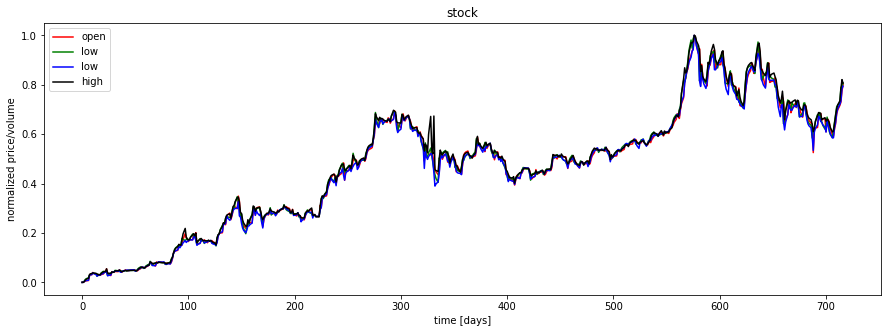

In [22]:
plt.figure(figsize=(15, 5));
plt.plot(norm_df.open.values, color='red', label='open')
plt.plot(norm_df.close.values, color='green', label='low')
plt.plot(norm_df.low.values, color='blue', label='low')
plt.plot(norm_df.high.values, color='black', label='high')

plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

In [23]:
norm_df1 = norm_df.copy(deep = True)

norm_df1 = norm_df1.drop(columns = ['date'])

norm_df1 = norm_df1[['open', 'high', 'low', 'ind_neg', 'ind_neu', 'ind_pos', 'close']]

output_labels1 = norm_df1.pop('close')

norm_df1

,open,high,low,ind_neg,ind_neu,ind_pos
0,0.000000,0.001377,0.000000,0.278674,0.176300,0.143917
1,0.001635,0.000000,0.000178,0.278874,0.211060,0.100014
2,0.003037,0.003175,0.004461,0.273078,0.193756,0.116132
3,0.005531,0.009961,0.006570,0.208868,0.209484,0.121271
4,0.006778,0.013354,0.007624,0.272524,0.174122,0.115136
...,...,...,...,...,...,...
712,0.707171,0.726699,0.711998,0.199406,0.422535,0.196778
713,0.716166,0.734428,0.720936,0.273004,0.648594,0.313788
714,0.729512,0.783022,0.734136,0.256412,0.670452,0.486741
715,0.773887,0.820865,0.783347,0.356284,0.592720,0.353743


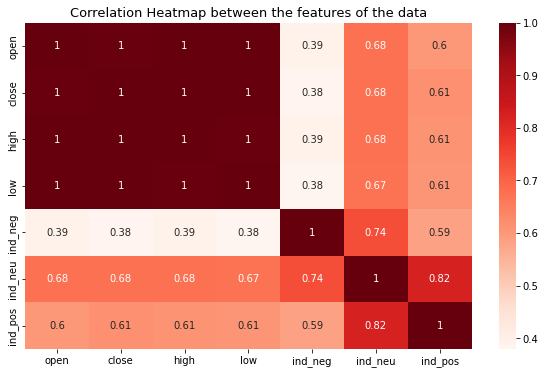

In [24]:
plt.figure(figsize=(10,6))
sns.heatmap(norm_df.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Correlation Heatmap between the features of the data', fontsize=13)
plt.show()

In [25]:
norm_df1 = norm_df1.to_numpy()
output_labels1 = output_labels1.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(norm_df1, output_labels1, test_size = 0.2, random_state = 3, shuffle=False)

In [26]:
model = Sequential()

#opt = SGD(lr=0.0001)
#opt = RMSprop()

model.add(Dense(256, input_shape=(X_train.shape[1],),  kernel_regularizer='l2'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse', 'mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1792      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 45,569
Trainable params: 45,569
Non-traina

2022-05-10 18:33:53.660860: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-10 18:33:53.660885: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Legion): /proc/driver/nvidia/version does not exist
2022-05-10 18:33:53.661588: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
history = model.fit(X_train, y_train, epochs=10, batch_size=20, verbose=1, shuffle=True)

Epoch 1/10
29/29 [==============================] - 0s 1ms/step - loss: 0.1318 - mse: 0.0246 - mae: 0.0982
Epoch 2/10
29/29 [==============================] - 0s 2ms/step - loss: 0.0782 - mse: 2.3706e-04 - mae: 0.0120
Epoch 3/10
29/29 [==============================] - 0s 2ms/step - loss: 0.0519 - mse: 1.4954e-04 - mae: 0.0088
Epoch 4/10
29/29 [==============================] - 0s 1ms/step - loss: 0.0329 - mse: 1.3652e-04 - mae: 0.0084
Epoch 5/10
29/29 [==============================] - 0s 2ms/step - loss: 0.0203 - mse: 1.7145e-04 - mae: 0.0096
Epoch 6/10
29/29 [==============================] - 0s 2ms/step - loss: 0.0122 - mse: 1.6551e-04 - mae: 0.0096
Epoch 7/10
29/29 [==============================] - 0s 2ms/step - loss: 0.0073 - mse: 1.3862e-04 - mae: 0.0084
Epoch 8/10
29/29 [==============================] - 0s 2ms/step - loss: 0.0044 - mse: 1.7267e-04 - mae: 0.0099
Epoch 9/10
29/29 [==============================] - 0s 2ms/step - loss: 0.0027 - mse: 1.6419e-04 - mae: 0.0094
Epoch

In [28]:
def print_metrics(model, X_test, y_test):
    
    n_points = X_train.shape[0] #number of datapoints
    n_features = X_train.shape[1] #number of features

    #predict probabilities for test set
    y_hat = model.predict(X_test, verbose=0)
    
    #reduce to 1d array
    y_hat = y_hat[:, 0]

    var = explained_variance_score(y_test.reshape(-1,1), y_hat)
    print('Variance:\t%f' % var)

    r2 = r2_score(y_test.reshape(-1,1), y_hat)
    print('R2 Score:\t%f' % r2)

    adj_r2 = 1-(1-r2)*(n_points-1)/(n_points-n_features-1)
    print('Adj R2 Score:\t%f' % adj_r2)

    var2 = max_error(y_test.reshape(-1,1), y_hat)
    print('Max Error:\t%f' % var2)

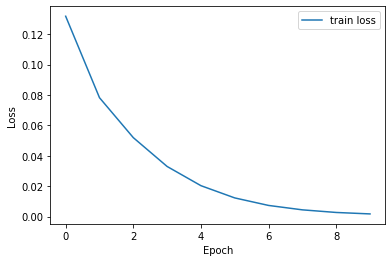

In [29]:
plt.plot(history.history['loss'], label='train loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

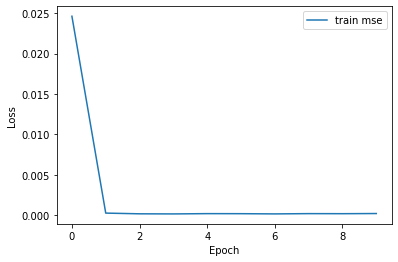

In [30]:
plt.plot(history.history['mse'], label='train mse')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

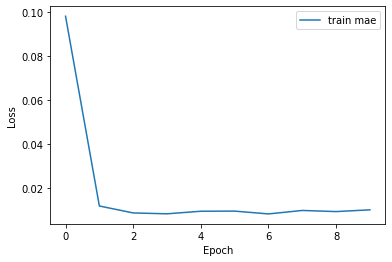

In [31]:
plt.plot(history.history['mae'], label='train mae')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [32]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 1ms/step - loss: 0.0022 - mse: 0.0011 - mae: 0.0274


[0.002235475927591324, 0.0010630079777911305, 0.027428261935710907]

In [33]:
print_metrics(model, X_test, y_test)

Variance:	0.955112
R2 Score:	0.901868
Adj R2 Score:	0.900827
Max Error:	0.084533


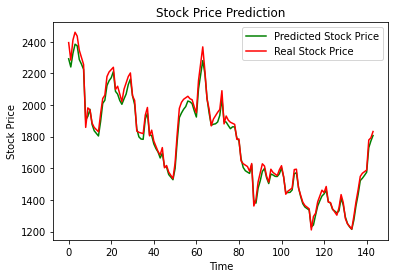

In [34]:
predicted  = model.predict(X_test)
test_label = y_test.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(X_train)

for j in range(len_t , len_t + len(X_test)):
    temp = output_labels_unscaled[j]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp

plt.plot(predicted, color = 'green', label = 'Predicted Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [35]:
norm_df2 = norm_df.copy(deep = True)

#norm_df2 = norm_df2.drop(columns = ['date', 'open', 'high', 'low'])

norm_df2 = norm_df2.drop(columns = ['date', 'open'])

norm_df2 = norm_df2[['ind_neg', 'ind_neu', 'ind_pos', 'close']]

output_labels2 = norm_df2.pop('close')

norm_df2

,ind_neg,ind_neu,ind_pos
0,0.278674,0.176300,0.143917
1,0.278874,0.211060,0.100014
2,0.273078,0.193756,0.116132
3,0.208868,0.209484,0.121271
4,0.272524,0.174122,0.115136
...,...,...,...
712,0.199406,0.422535,0.196778
713,0.273004,0.648594,0.313788
714,0.256412,0.670452,0.486741
715,0.356284,0.592720,0.353743


In [36]:
from sklearn.model_selection import train_test_split

norm_df2 = norm_df2.to_numpy()
output_labels2 = output_labels2.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(norm_df2, output_labels2, test_size = 0.2, random_state = 3, shuffle=False)

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()

#opt = SGD(lr=0.0001)
#opt = RMSprop()

model.add(Dense(256, input_shape=(X_train.shape[1],),  kernel_regularizer='l2'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse', 'mae'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               1024      
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 44,801
Trainable params: 44,801
Non-trai

In [38]:
history = model.fit(X_train, y_train, epochs=10, batch_size=20, verbose=1, shuffle=True)

Epoch 1/10
29/29 [==============================] - 0s 1ms/step - loss: 0.1034 - mse: 0.0485 - mae: 0.1771
Epoch 2/10
29/29 [==============================] - 0s 2ms/step - loss: 0.0651 - mse: 0.0269 - mae: 0.1347
Epoch 3/10
29/29 [==============================] - 0s 2ms/step - loss: 0.0511 - mse: 0.0263 - mae: 0.1354
Epoch 4/10
29/29 [==============================] - 0s 2ms/step - loss: 0.0419 - mse: 0.0259 - mae: 0.1341
Epoch 5/10
29/29 [==============================] - 0s 2ms/step - loss: 0.0360 - mse: 0.0255 - mae: 0.1326
Epoch 6/10
29/29 [==============================] - 0s 2ms/step - loss: 0.0334 - mse: 0.0262 - mae: 0.1333
Epoch 7/10
29/29 [==============================] - 0s 1ms/step - loss: 0.0313 - mse: 0.0261 - mae: 0.1348
Epoch 8/10
29/29 [==============================] - 0s 1ms/step - loss: 0.0311 - mse: 0.0270 - mae: 0.1360
Epoch 9/10
29/29 [==============================] - 0s 1ms/step - loss: 0.0304 - mse: 0.0271 - mae: 0.1363
Epoch 10/10
29/29 [==================

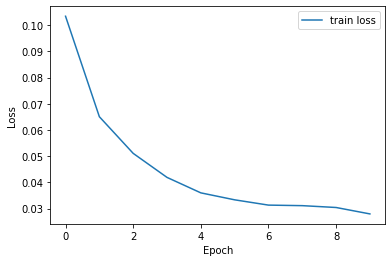

In [39]:
plt.plot(history.history['loss'], label='train loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

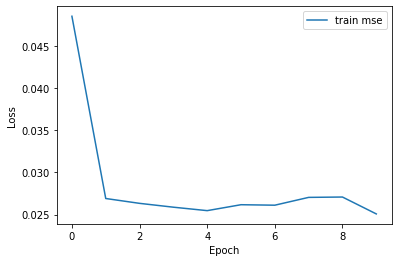

In [40]:
plt.plot(history.history['mse'], label='train mse')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

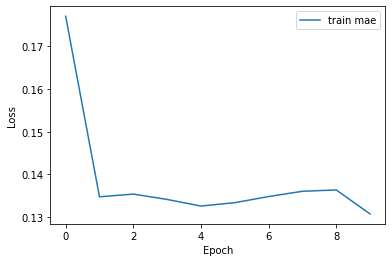

In [41]:
plt.plot(history.history['mae'], label='train mae')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [42]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 974us/step - loss: 0.0597 - mse: 0.0570 - mae: 0.2057


[0.05972476676106453, 0.057021744549274445, 0.2056533694267273]

In [43]:
print_metrics(model, X_test, y_test)

Variance:	-0.417405
R2 Score:	-4.263999
Adj R2 Score:	-4.291753
Max Error:	0.568709


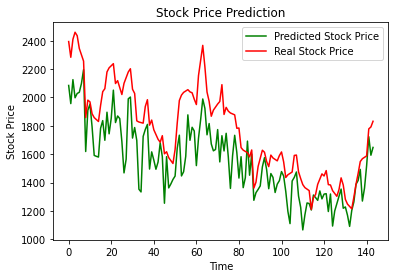

In [44]:
predicted  = model.predict(X_test)
test_label = y_test.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(X_train)

for j in range(len_t , len_t + len(X_test)):
    temp = output_labels_unscaled[j]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp

plt.plot(predicted, color = 'green', label = 'Predicted Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Using Previous Day's Open Value as a Feature